**About** : This notebook is used to train models.

`pip install  jupyter-server-proxy`

`jupyter serverextension enable jupyter_server_proxy`

In [15]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
cd ../src/

/workspace/kaggle_benetech/src


## Initialization

### Imports

In [17]:
import os
import torch

print(torch.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
device = torch.cuda.get_device_name(0)
print(device)

1.14.0a0+410ce96
Tesla V100-SXM2-32GB-LS


In [18]:
# import plotly.io as pio
# pio.renderers.default = "iframe"

In [33]:
import os
import sys
import cv2
import glob
import json
import cudf
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import *
from numerize.numerize import numerize

pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [20]:
from params import *
from utils.plots import *
from data.dataset import *
from data.preparation import *

In [206]:
def get_annotations(annotations_path="../input/train/annotations"):
    annotations = []
    for annotation_path in tqdm(os.listdir(annotations_path)):
        with open(f"{annotations_path}/{annotation_path}") as annotation_f:
            annots = json.load(annotation_f)
            annots['id'] = annotation_path[:-5]
            annotations.append(annots)
    return annotations

In [207]:
annotations = get_annotations()

100%|██████████| 60578/60578 [05:04<00:00, 199.15it/s]


In [208]:
df = pd.DataFrame(annotations)

In [209]:
df = df[['id', 'source', 'chart-type', 'plot-bb', 'text', 'axes', 'data-series']]

In [210]:
# import ast

# for c in ['plot-bb', 'text', 'axes']:
#     print(c)
#     df[c] = df[c].parallel_apply(ast.literal_eval)

In [211]:
# def literal_eval(x):
#     try:
#         return ast.literal_eval(x)
#     except:
# #         print(x)
#         return ast.literal_eval(x.replace('nan', 'None'))
    
# df['data-series'] = df['data-series'].parallel_apply(literal_eval)

In [213]:
df.head()

,id,source,chart-type,plot-bb,text,axes,data-series
0,36079df3b5b2,generated,dot,"{'height': 221, 'width': 448, 'x0': 62, 'y0': 35}","[{'id': 0, 'polygon': {'x0': 165, 'x1': 484, 'x2': 484, 'x3': 165, 'y0': 5, 'y1': 5, 'y2': 19, '...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'x': 101, 'y': 256}}, {'id': 15, 'tick_pt': {'x': 1...","[{'x': 'Guest 1519', 'y': 3}, {'x': 'Guest 1520', 'y': 5}, {'x': 'Guest 1521', 'y': 9}, {'x': 'G..."
1,6b90554d6f10,generated,vertical_bar,"{'height': 183, 'width': 398, 'x0': 58, 'y0': 38}","[{'id': 0, 'polygon': {'x0': 81, 'x1': 440, 'x2': 440, 'x3': 81, 'y0': 6, 'y1': 6, 'y2': 21, 'y3...","{'x-axis': {'ticks': [{'id': 10, 'tick_pt': {'x': 72, 'y': 221}}, {'id': 11, 'tick_pt': {'x': 10...","[{'x': '2013', 'y': 78.0518889394629}, {'x': '2014', 'y': 102.3031406463359}, {'x': '2015', 'y':..."
2,0cfa6023c813,generated,dot,"{'height': 239, 'width': 418, 'x0': 80, 'y0': 44}","[{'id': 0, 'polygon': {'x0': 132, 'x1': 403, 'x2': 403, 'x3': 132, 'y0': 8, 'y1': 8, 'y2': 20, '...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'x': 123, 'y': 283}}, {'id': 15, 'tick_pt': {'x': 2...","[{'x': 'Day 316', 'y': 7}, {'x': 'Day 317', 'y': 3}, {'x': 'Day 318', 'y': 3}, {'x': 'Day 319', ..."
3,11fcdfbc8a87,generated,line,"{'height': 99, 'width': 438, 'x0': 60, 'y0': 75}","[{'id': 0, 'polygon': {'x0': 62, 'x1': 465, 'x2': 465, 'x3': 62, 'y0': 8, 'y1': 8, 'y2': 63, 'y3...","{'x-axis': {'ticks': [{'id': 15, 'tick_pt': {'x': 81, 'y': 174}}, {'id': 16, 'tick_pt': {'x': 13...","[{'x': 'Low-income countries', 'y': 100.69090277001776}, {'x': 'Lower-middle-income...', 'y': 10..."
4,8ef1ba207d2f,generated,line,"{'height': 107, 'width': 447, 'x0': 60, 'y0': 66}","[{'id': 0, 'polygon': {'x0': 82, 'x1': 433, 'x2': 433, 'x3': 82, 'y0': 7, 'y1': 7, 'y2': 49, 'y3...","{'x-axis': {'ticks': [{'id': 3, 'tick_pt': {'x': 78, 'y': 173}}, {'id': 4, 'tick_pt': {'x': 124,...","[{'x': 'Denmark', 'y': 17.613661545920362}, {'x': 'Djibouti', 'y': 19.552581938058893}, {'x': 'D..."


### Process columns

In [214]:
df['plot_x0'] = df['plot-bb'].apply(lambda x: x['x0'])
df['plot_y0'] = df['plot-bb'].apply(lambda x: x['y0'])
df['plot_h'] = df['plot-bb'].apply(lambda x: x['height'])
df['plot_w'] = df['plot-bb'].apply(lambda x: x['width'])

In [215]:
df['x_axis'] = df['axes'].apply(lambda x: x['x-axis'])
df['y_axis'] = df['axes'].apply(lambda x: x['y-axis'])

df['x_ticks_type'] = df['x_axis'].apply(lambda x: x['tick-type'])
df['x_values_type'] = df['x_axis'].apply(lambda x: x['values-type'])
df['y_ticks_type'] = df['y_axis'].apply(lambda x: x['tick-type'])
df['y_values_type'] = df['y_axis'].apply(lambda x: x['values-type'])

df['x_ticks'] = df['x_axis'].apply(lambda x: x['ticks'])
df['y_ticks'] = df['y_axis'].apply(lambda x: x['ticks'])

In [216]:
df.head()

,id,source,chart-type,plot-bb,text,axes,data-series,plot_x0,plot_y0,plot_h,plot_w,x_axis,y_axis,x_ticks_type,x_values_type,y_ticks_type,y_values_type,x_ticks,y_ticks
0,36079df3b5b2,generated,dot,"{'height': 221, 'width': 448, 'x0': 62, 'y0': 35}","[{'id': 0, 'polygon': {'x0': 165, 'x1': 484, 'x2': 484, 'x3': 165, 'y0': 5, 'y1': 5, 'y2': 19, '...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'x': 101, 'y': 256}}, {'id': 15, 'tick_pt': {'x': 1...","[{'x': 'Guest 1519', 'y': 3}, {'x': 'Guest 1520', 'y': 5}, {'x': 'Guest 1521', 'y': 9}, {'x': 'G...",62,35,221,448,"{'ticks': [{'id': 14, 'tick_pt': {'x': 101, 'y': 256}}, {'id': 15, 'tick_pt': {'x': 177, 'y': 25...","{'ticks': [{'id': 3, 'tick_pt': {'x': 62, 'y': 35}}, {'id': 4, 'tick_pt': {'x': 62, 'y': 57}}, {...",markers,categorical,markers,numerical,"[{'id': 14, 'tick_pt': {'x': 101, 'y': 256}}, {'id': 15, 'tick_pt': {'x': 177, 'y': 256}}, {'id'...","[{'id': 3, 'tick_pt': {'x': 62, 'y': 35}}, {'id': 4, 'tick_pt': {'x': 62, 'y': 57}}, {'id': 5, '..."
1,6b90554d6f10,generated,vertical_bar,"{'height': 183, 'width': 398, 'x0': 58, 'y0': 38}","[{'id': 0, 'polygon': {'x0': 81, 'x1': 440, 'x2': 440, 'x3': 81, 'y0': 6, 'y1': 6, 'y2': 21, 'y3...","{'x-axis': {'ticks': [{'id': 10, 'tick_pt': {'x': 72, 'y': 221}}, {'id': 11, 'tick_pt': {'x': 10...","[{'x': '2013', 'y': 78.0518889394629}, {'x': '2014', 'y': 102.3031406463359}, {'x': '2015', 'y':...",58,38,183,398,"{'ticks': [{'id': 10, 'tick_pt': {'x': 72, 'y': 221}}, {'id': 11, 'tick_pt': {'x': 103, 'y': 221...","{'ticks': [{'id': 3, 'tick_pt': {'x': 58, 'y': 38}}, {'id': 4, 'tick_pt': {'x': 58, 'y': 69}}, {...",separators,categorical,markers,numerical,"[{'id': 10, 'tick_pt': {'x': 72, 'y': 221}}, {'id': 11, 'tick_pt': {'x': 103, 'y': 221}}, {'id':...","[{'id': 3, 'tick_pt': {'x': 58, 'y': 38}}, {'id': 4, 'tick_pt': {'x': 58, 'y': 69}}, {'id': 5, '..."
2,0cfa6023c813,generated,dot,"{'height': 239, 'width': 418, 'x0': 80, 'y0': 44}","[{'id': 0, 'polygon': {'x0': 132, 'x1': 403, 'x2': 403, 'x3': 132, 'y0': 8, 'y1': 8, 'y2': 20, '...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'x': 123, 'y': 283}}, {'id': 15, 'tick_pt': {'x': 2...","[{'x': 'Day 316', 'y': 7}, {'x': 'Day 317', 'y': 3}, {'x': 'Day 318', 'y': 3}, {'x': 'Day 319', ...",80,44,239,418,"{'ticks': [{'id': 14, 'tick_pt': {'x': 123, 'y': 283}}, {'id': 15, 'tick_pt': {'x': 206, 'y': 28...","{'ticks': [{'id': 3, 'tick_pt': {'x': 80, 'y': 44}}, {'id': 4, 'tick_pt': {'x': 80, 'y': 68}}, {...",markers,categorical,markers,numerical,"[{'id': 14, 'tick_pt': {'x': 123, 'y': 283}}, {'id': 15, 'tick_pt': {'x': 206, 'y': 283}}, {'id'...","[{'id': 3, 'tick_pt': {'x': 80, 'y': 44}}, {'id': 4, 'tick_pt': {'x': 80, 'y': 68}}, {'id': 5, '..."
3,11fcdfbc8a87,generated,line,"{'height': 99, 'width': 438, 'x0': 60, 'y0': 75}","[{'id': 0, 'polygon': {'x0': 62, 'x1': 465, 'x2': 465, 'x3': 62, 'y0': 8, 'y1': 8, 'y2': 63, 'y3...","{'x-axis': {'ticks': [{'id': 15, 'tick_pt': {'x': 81, 'y': 174}}, {'id': 16, 'tick_pt': {'x': 13...","[{'x': 'Low-income countries', 'y': 100.69090277001776}, {'x': 'Lower-middle-income...', 'y': 10...",60,75,99,438,"{'ticks': [{'id': 15, 'tick_pt': {'x': 81, 'y': 174}}, {'id': 16, 'tick_pt': {'x': 130, 'y': 174...","{'ticks': [{'id': 14, 'tick_pt': {'x': 60, 'y': 75}}, {'id': 13, 'tick_pt': {'x': 60, 'y': 84}},...",markers,categorical,markers,numerical,"[{'id': 15, 'tick_pt': {'x': 81, 'y': 174}}, {'id': 16, 'tick_pt': {'x': 130, 'y': 174}}, {'id':...","[{'id': 14, 'tick_pt': {'x': 60, 'y': 75}}, {'id': 13, 'tick_pt': {'x': 60, 'y': 84}}, {'id': 12..."
4,8ef1ba207d2f,generated,line,"{'height': 107, 'width': 447, 'x0': 60, 'y0': 66}","[{'id': 0, 'polygon': {'x0': 82, 'x1': 433, 'x2': 433, 'x3': 82, 'y0': 7, 'y1': 7, 'y2': 49, 'y3...","{'x-axis': {'ticks': [{'id': 3, 'tick_pt': {'x': 78, 'y': 173}}, {'id': 4, 'tick_pt': {'x': 124,...","[{'x': 'Denmark', 'y': 17.613661545920362}, {'x': 'Djibouti', 'y': 19.552581938058893}, {'x': 'D...",60,66,107,447,"{'ticks': [{'id': 3, 'tick_pt': 

### Texts & ticks

In [217]:
df_text = df[['id', 'text']].explode('text').reset_index(drop=True)

df_text = df_text.rename(columns={"id": "chart_id"})

df_text['id'] = df_text['text'].apply(lambda x: x['id'])
df_text["polygon"] = df_text['text'].apply(lambda x: x['polygon'])
df_text['text'] = df_text['text'].apply(lambda x: x['text'])
df_text["polygon"] = df_text["polygon"].apply(lambda x: list(x.values()))

In [218]:
df_x_ticks = df[['id', 'x_ticks']].explode('x_ticks').rename(columns={"x_ticks": "ticks"})
df_x_ticks['axis'] = "x"

df_y_ticks = df[['id', 'y_ticks']].explode('y_ticks').rename(columns={"y_ticks": "ticks"})
df_y_ticks['axis'] = "y"

df_ticks = pd.concat([df_x_ticks, df_y_ticks], ignore_index=True)

df_ticks = df_ticks.rename(columns={"id": "chart_id"})

df_ticks['id'] = df_ticks['ticks'].apply(lambda x: x['id'] if isinstance(x, dict) else np.nan)
df_ticks['x'] = df_ticks['ticks'].apply(lambda x: x['tick_pt']['x'] if isinstance(x, dict) else np.nan)
df_ticks['y'] = df_ticks['ticks'].apply(lambda x: x['tick_pt']['y'] if isinstance(x, dict) else np.nan)

df_ticks = df_ticks.dropna(axis=0)
df_ticks['id'] = df_ticks['id'].astype(int)
df_ticks = df_ticks.drop("ticks", axis=1)

In [219]:
df_text = df_text.merge(df_ticks, on=['chart_id', "id"], how="left")

In [220]:
df_text.head()

,chart_id,text,id,polygon,axis,x,y
0,36079df3b5b2,Number of days Guest staying in Hotel in November 2021,0,"[165, 484, 484, 165, 5, 5, 19, 19]",NaN,NaN,NaN
1,36079df3b5b2,no. of days,1,"[6, 40, 40, 6, 130, 130, 159, 159]",NaN,NaN,NaN
2,36079df3b5b2,Guest Number,2,"[250, 329, 329, 250, 281, 281, 293, 293]",NaN,NaN,NaN
3,36079df3b5b2,10,3,"[40, 53, 53, 40, 30, 30, 40, 40]",y,62.0,35.0
4,36079df3b5b2,9,4,"[45, 53, 53, 45, 52, 52, 62, 62]",y,62.0,57.0


### Target

In [221]:
df_target = df[['id', 'data-series']].explode('data-series').reset_index(drop=True)

In [224]:
df_target['x'] = df_target['data-series'].apply(lambda x: x['x'])
df_target['y'] = df_target['data-series'].apply(lambda x: x['y'])

In [226]:
df_target.drop('data-series', axis=1, inplace=True)

In [228]:
df_target.head()

,id,x,y
0,36079df3b5b2,Guest 1519,3
1,36079df3b5b2,Guest 1520,5
2,36079df3b5b2,Guest 1521,9
3,36079df3b5b2,Guest 1522,2
4,36079df3b5b2,Guest 1523,7


### Finalize

In [229]:
df = df.drop(["plot-bb", 'text', "axes", "x_axis", "y_axis", "x_ticks", "y_ticks"], axis=1)

In [233]:
df.to_csv('../input/df_train.csv', index=False)
df_text.to_csv('../input/texts.csv', index=False)
df_target.to_csv('../input/y_train.csv', index=False)

In [230]:
df.head()

,id,source,chart-type,data-series,plot_x0,plot_y0,plot_h,plot_w,x_ticks_type,x_values_type,y_ticks_type,y_values_type
0,36079df3b5b2,generated,dot,"[{'x': 'Guest 1519', 'y': 3}, {'x': 'Guest 1520', 'y': 5}, {'x': 'Guest 1521', 'y': 9}, {'x': 'G...",62,35,221,448,markers,categorical,markers,numerical
1,6b90554d6f10,generated,vertical_bar,"[{'x': '2013', 'y': 78.0518889394629}, {'x': '2014', 'y': 102.3031406463359}, {'x': '2015', 'y':...",58,38,183,398,separators,categorical,markers,numerical
2,0cfa6023c813,generated,dot,"[{'x': 'Day 316', 'y': 7}, {'x': 'Day 317', 'y': 3}, {'x': 'Day 318', 'y': 3}, {'x': 'Day 319', ...",80,44,239,418,markers,categorical,markers,numerical
3,11fcdfbc8a87,generated,line,"[{'x': 'Low-income countries', 'y': 100.69090277001776}, {'x': 'Lower-middle-income...', 'y': 10...",60,75,99,438,markers,categorical,markers,numerical
4,8ef1ba207d2f,generated,line,"[{'x': 'Denmark', 'y': 17.613661545920362}, {'x': 'Djibouti', 'y': 19.552581938058893}, {'x': 'D...",60,66,107,447,markers,categorical,markers,numerical


### Plot

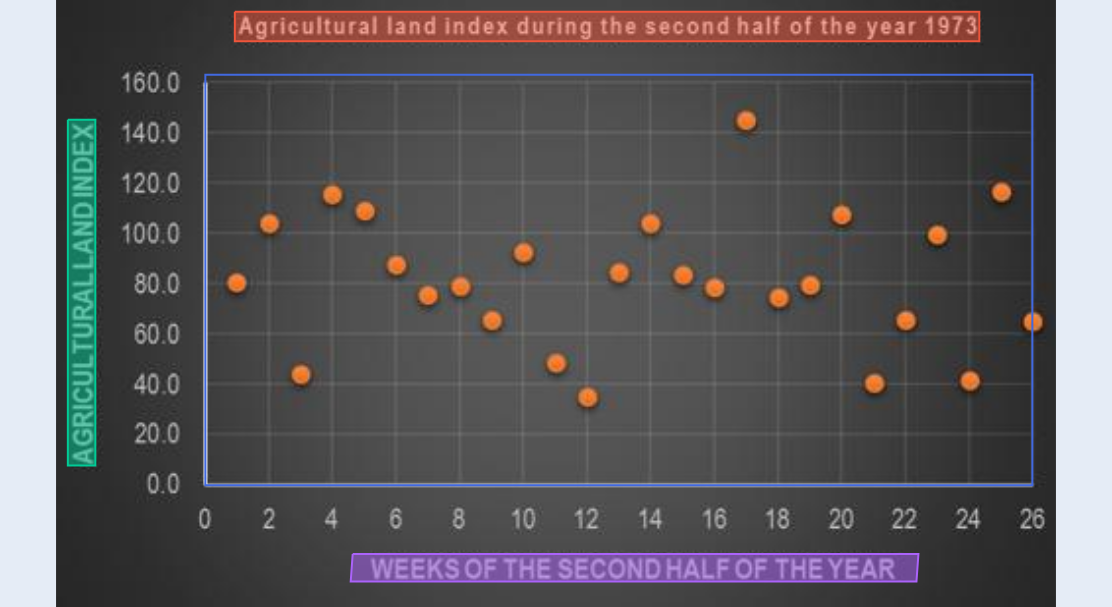

In [231]:
fig = plot_annotated_image("6ce4bc728dd5")

Done ! 